# AC 221 Final Project Notebook

In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

## Reading NYPD Stop, Question and Frisk Data

In [2]:
sqf_df = pd.read_csv('../data/sqf-2018.csv')
print(sqf_df.shape)
sqf_df.head()

(11008, 83)


,STOP_FRISK_ID,STOP_FRISK_DATE,Stop Frisk Time,YEAR2,MONTH2,DAY2,STOP_WAS_INITIATED,RECORD_STATUS_CODE,ISSUING_OFFICER_RANK,ISSUING_OFFICER_COMMAND_CODE,SUPERVISING_OFFICER_RANK,SUPERVISING_OFFICER_COMMAND_CODE,SUPERVISING_ACTION_CORRESPONDING_ACTIVITY_LOG_ENTRY_REVIEWED,LOCATION_IN_OUT_CODE,JURISDICTION_CODE,JURISDICTION_DESCRIPTION,OBSERVED_DURATION_MINUTES,SUSPECTED_CRIME_DESCRIPTION,STOP_DURATION_MINUTES,OFFICER_EXPLAINED_STOP_FLAG,OFFICER_NOT_EXPLAINED_STOP_DESCRIPTION,OTHER_PERSON_STOPPED_FLAG,SUSPECT_ARRESTED_FLAG,SUSPECT_ARREST_OFFENSE,SUMMONS_ISSUED_FLAG,SUMMONS_OFFENSE_DESCRIPTION,OFFICER_IN_UNIFORM_FLAG,ID_CARD_IDENTIFIES_OFFICER_FLAG,SHIELD_IDENTIFIES_OFFICER_FLAG,VERBAL_IDENTIFIES_OFFICER_FLAG,FRISKED_FLAG,SEARCHED_FLAG,OTHER_CONTRABAND_FLAG,FIREARM_FLAG,KNIFE_CUTTER_FLAG,OTHER_WEAPON_FLAG,WEAPON_FOUND_FLAG,PHYSICAL_FORCE_CEW_FLAG,PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG,PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG,PHYSICAL_FORCE_OC_SPRAY_USED_FLAG,PHYSICAL_FORCE_OTHER_FLAG,PHYSICAL_FORCE_RESTRAINT_USED_FLAG,PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG,PHYSICAL_FORCE_WEAPON_IMPACT_FLAG,BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG,BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG,SUSPECTS_ACTIONS_CASING_FLAG,SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG,SUSPECTS_ACTIONS_DECRIPTION_FLAG,SUSPECTS_ACTIONS_DRUG_TRANSACTIONS_FLAG,SUSPECTS_ACTIONS_IDENTIFY_CRIME_PATTERN_FLAG,SUSPECTS_ACTIONS_LOOKOUT_FLAG,SUSPECTS_ACTIONS_OTHER_FLAG,SUSPECTS_ACTIONS_PROXIMITY_TO_SCENE_FLAG,SEARCH_BASIS_ADMISSION_FLAG,SEARCH_BASIS_CONSENT_FLAG,SEARCH_BASIS_HARD_OBJECT_FLAG,SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG,SEARCH_BASIS_OTHER_FLAG,SEARCH_BASIS_OUTLINE_FLAG,DEMEANOR_CODE,DEMEANOR_OF_PERSON_STOPPED,SUSPECT_REPORTED_AGE,SUSPECT_SEX,SUSPECT_RACE_DESCRIPTION,SUSPECT_HEIGHT,SUSPECT_WEIGHT,SUSPECT_BODY_BUILD_TYPE,SUSPECT_EYE_COLOR,SUSPECT_HAIR_COLOR,SUSPECT_OTHER_DESCRIPTION,STOP_LOCATION_PRECINCT,STOP_LOCATION_SECTOR_CODE,STOP_LOCATION_APARTMENT,STOP_LOCATION_FULL_ADDRESS,STOP_LOCATION_PREMISES_NAME,STOP_LOCATION_STREET_NAME,STOP_LOCATION_X,STOP_LOCATION_Y,STOP_LOCATION_ZIP_CODE,STOP_LOCATION_PATROL_BORO_NAME,STOP_LOCATION_BORO_NAME
0,1,1/1/18,19:04:00,2018,January,Monday,Based on C/W on Scene,APP,POM,1,SGT,1,Y,(null),P,PSB,0,MENACING,18,Y,(null),Y,N,(null),N,(null),Y,(null),(null),(null),Y,N,N,(null),(null),(null),N,(null),(null),(null),(null),(null),(null),Y,(null),(null),(null),(null),Y,Y,(null),(null),(null),(null),Y,(null),(null),(null),(null),(null),(null),DE,COOPERATIVE,(null),MALE,WHITE,5.1,170,MED,BRO,BLK,(null),1,G,(null),VARICK STREET && FRANKLIN STREET,(null),VARICK STREET,982327,201274,(null),PBMS,MANHATTAN
1,2,1/1/18,23:00:00,2018,January,Monday,Based on Radio Run,APP,POM,34,SGT,34,N,O,P,PSB,1,CPW,15,Y,(null),N,N,(null),N,(null),Y,(null),(null),(null),Y,Y,N,(null),(null),(null),N,(null),Y,(null),(null),(null),(null),(null),(null),(null),(null),(null),(null),Y,(null),(null),(null),(null),(null),(null),(null),(null),(null),Y,(null),DE,NERVOUS,26,MALE,BLACK HISPANIC,6.1,250,HEA,BRO,BLK,(null),34,C,(null),DYCKMAN STREET && POST AVENUE,(null),DYCKMAN STREET,1004892,253548,(null),PBMN,MANHATTAN
2,3,1/1/18,23:55:00,2018,January,Monday,Based on Radio Run,APP,POM,808,SGT,808,Y,I,H,Housing,0,GRAND LARCENY,10,Y,(null),N,N,(null),N,(null),Y,(null),(null),(null),Y,N,N,(null),(null),(null),N,(null),(null),(null),(null),(null),(null),Y,(null),Y,(null),(null),(null),Y,(null),(null),(null),(null),Y,(null),(null),(null),(null),(null),(null),DE,RELIEVED,40,MALE,WHITE HISPANIC,5.5,150,THN,BRO,BLD,(null),43,B,4M,2245 RANDALL AVENUE,(null),RANDALL AVENUE,1026706,237776,(null),PBBX,BRONX
3,4,1/1/18,3:23:00,2018,January,Monday,Based on Radio Run,APP,POM,63,SGT,63,Y,O,P,PSB,2,ROBBERY,15,Y,(null),Y,Y,ROBBERY,N,(null),Y,(null),(null),(null),Y,Y,N,(null),(null),(null),N,(null),(null),(null),(null),(null),Y,Y,(null),Y,(null),(null),(null),Y,(null),(null),(null),Y,(null),(null),(null),(null),(null),Y,(null),DE,COMPLAIN,38,MALE,AMERICAN INDIAN/ALASKAN NATIVE,5.1,

## Data Cleaning

In [3]:
# drop unnecessary variables
def drop_unnecessary_variables(df, variables_list):
    return df.drop(variables_list, axis=1)

# dealing with missing values
def deal_with_missing_values(df):
    return df.replace('(null)', np.nan)

# convert Y/N flag columns to boolean
def convert_flags_to_boolean(df):
    binary_map_dict = {'Y': 1, 'N': 0, np.nan: 0, 'I':1, 'S':1, 'V':1}
    
    # carrying out this operation for flags
    for col in df.columns: 
        if 'FLAG' in col:
            df[col] = list(map(lambda x: binary_map_dict[x], df[col]))
    return df
            
# convert categorical variables to one-hot-encoding
def make_one_hot(df, var):
    one_hot = pd.get_dummies(df[var], drop_first=True)
    df = df.drop(var,axis = 1)
    df = df.join(one_hot)
    return df

# specific transformations for height: converting feet to inches
def replace_feet_inches(h):
    try:
        height = str(h).split('.')
        return int(height[0])*12 + int(height[1])
    except:
        return h
    
# specific transformations
def specific_variable_transformations(df):
    # height
    df = replace_with_function(df, 'SUSPECT_HEIGHT', replace_feet_inches)
    return df

# replaces values in a variable with a mapping
def replace_with_map(df, var, map_dict):
    df[var] = list(map(lambda x: map_dict[x], df[var]))
    return df

# replaces values in a variable with a function
def replace_with_function(df, var, function):
    df[var] = list(map(lambda x: function(x), df[var]))
    return df

In [4]:
def data_cleaning_pipeline(df):
    # carrying out data cleaning using helper functions defined above
    unnecessary_variables = ['STOP_LOCATION_PREMISES_NAME', 'STOP_FRISK_ID', 'YEAR2', 'RECORD_STATUS_CODE']
    df = drop_unnecessary_variables(df, unnecessary_variables)

    # dealing with missing values
    df = deal_with_missing_values(df)

    # convert Y/N flags to booleans and doing the same for gender
    df = convert_flags_to_boolean(df)
    df = replace_with_map(df, 'SUSPECT_SEX', {'MALE': 1, 'FEMALE': 0, np.nan: np.nan})
    
    month_list = 'January February March April May June July August September October November December'.split()
    month_dict = {month:i for i, month in enumerate(month_list)}
    df = replace_with_map(df, 'MONTH2', month_dict)

    day_list = 'Monday Tuesday Wednesday Thursday Friday Saturday Sunday'.split()
    day_dict = {month:i for i, month in enumerate(day_list)}
    df = replace_with_map(df, 'DAY2', day_dict)

    stop_dict = {'Based on C/W on Scene': 0, 'Based on Radio Run': 1, 'Based on Self Initiated': 2}
    df = replace_with_map(df, 'STOP_WAS_INITIATED', stop_dict)

    # specific variable transformations
    df = specific_variable_transformations(df)

    # convert categorical variables to one-hot
    df = make_one_hot(df, 'SUSPECT_RACE_DESCRIPTION')
    df = make_one_hot(df, 'SUSPECTED_CRIME_DESCRIPTION')
    df = make_one_hot(df, 'STOP_LOCATION_BORO_NAME')
    
    # done
    print('Cleaned dataframe shape: {}'.format(df.shape))
    return df

In [5]:
clean_sqf_df = data_cleaning_pipeline(sqf_df)
clean_sqf_df.head()

Cleaned dataframe shape: (11008, 111)


,STOP_FRISK_DATE,Stop Frisk Time,MONTH2,DAY2,STOP_WAS_INITIATED,ISSUING_OFFICER_RANK,ISSUING_OFFICER_COMMAND_CODE,SUPERVISING_OFFICER_RANK,SUPERVISING_OFFICER_COMMAND_CODE,SUPERVISING_ACTION_CORRESPONDING_ACTIVITY_LOG_ENTRY_REVIEWED,LOCATION_IN_OUT_CODE,JURISDICTION_CODE,JURISDICTION_DESCRIPTION,OBSERVED_DURATION_MINUTES,STOP_DURATION_MINUTES,OFFICER_EXPLAINED_STOP_FLAG,OFFICER_NOT_EXPLAINED_STOP_DESCRIPTION,OTHER_PERSON_STOPPED_FLAG,SUSPECT_ARRESTED_FLAG,SUSPECT_ARREST_OFFENSE,SUMMONS_ISSUED_FLAG,SUMMONS_OFFENSE_DESCRIPTION,OFFICER_IN_UNIFORM_FLAG,ID_CARD_IDENTIFIES_OFFICER_FLAG,SHIELD_IDENTIFIES_OFFICER_FLAG,VERBAL_IDENTIFIES_OFFICER_FLAG,FRISKED_FLAG,SEARCHED_FLAG,OTHER_CONTRABAND_FLAG,FIREARM_FLAG,KNIFE_CUTTER_FLAG,OTHER_WEAPON_FLAG,WEAPON_FOUND_FLAG,PHYSICAL_FORCE_CEW_FLAG,PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG,PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG,PHYSICAL_FORCE_OC_SPRAY_USED_FLAG,PHYSICAL_FORCE_OTHER_FLAG,PHYSICAL_FORCE_RESTRAINT_USED_FLAG,PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG,PHYSICAL_FORCE_WEAPON_IMPACT_FLAG,BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG,BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG,SUSPECTS_ACTIONS_CASING_FLAG,SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG,SUSPECTS_ACTIONS_DECRIPTION_FLAG,SUSPECTS_ACTIONS_DRUG_TRANSACTIONS_FLAG,SUSPECTS_ACTIONS_IDENTIFY_CRIME_PATTERN_FLAG,SUSPECTS_ACTIONS_LOOKOUT_FLAG,SUSPECTS_ACTIONS_OTHER_FLAG,...,SUSPECT_HEIGHT,SUSPECT_WEIGHT,SUSPECT_BODY_BUILD_TYPE,SUSPECT_EYE_COLOR,SUSPECT_HAIR_COLOR,SUSPECT_OTHER_DESCRIPTION,STOP_LOCATION_PRECINCT,STOP_LOCATION_SECTOR_CODE,STOP_LOCATION_APARTMENT,STOP_LOCATION_FULL_ADDRESS,STOP_LOCATION_STREET_NAME,STOP_LOCATION_X,STOP_LOCATION_Y,STOP_LOCATION_ZIP_CODE,STOP_LOCATION_PATROL_BORO_NAME,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,WHITE,WHITE HISPANIC,AUTO STRIPPIG,BURGLARY,CPSP,CPW,CRIMINAL MISCHIEF,CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE,CRIMINAL POSSESSION OF FORGED INSTRUMENT,CRIMINAL POSSESSION OF MARIHUANA,CRIMINAL SALE OF CONTROLLED SUBSTANCE,CRIMINAL SALE OF MARIHUANA,CRIMINAL TRESPASS,FORCIBLE TOUCHING,GRAND LARCENY,GRAND LARCENY AUTO,MAKING GRAFFITI,MENACING,MURDER,OTHER,PETIT LARCENY,PROSTITUTION,RAPE,RECKLESS ENDANGERMENT,ROBBERY,TERRORISM,THEFT OF SERVICES,UNAUTHORIZED USE OF A VEHICLE,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
0,1/1/18,19:04:00,0,0,0,POM,1,SGT,1,Y,NaN,P,PSB,0,18,1,NaN,1,0,NaN,0,NaN,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,...,61,170,MED,BRO,BLK,NaN,1,G,NaN,VARICK STREET && FRANKLIN STREET,VARICK STREET,982327,201274,NaN,PBMS,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1/1/18,23:00:00,0,0,1,POM,34,SGT,34,N,O,P,PSB,1,15,1,NaN,0,0,NaN,0,NaN,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,73,250,HEA,BRO,BLK,NaN,34,C,NaN,DYCKMAN STREET && POST AVENUE,DYCKMAN STREET,1004892,253548,NaN,PBMN,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1/1/18,23:55:00,0,0,1,POM,808,SGT,808,Y,I,H,Housing,0,10,1,NaN,0,0,NaN,0,NaN,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,...,65,150,THN,BRO,BLD,NaN,43,B,4M,2245 RANDALL AVENUE,RANDALL AVENUE,1026706,237776,NaN,PBBX,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1/1/18,3:23:00,0,0,1,POM,63,SGT,63,Y,O,P,PSB,2,15,1,NaN,1,1,ROBBERY,0,NaN,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,1,...,61,160,MED,BRO,BLK,NaN,63,B,NaN,EAST 38 STREET && AVENUE L,EAST 38 STREET,1001347,166195,NaN,PBBS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,1/1/18,3:23:00,0,0,1,POM,63,SGT,63,Y,NaN,P,PSB,2,15,1,NaN,1,1,ROBBERY,0,NaN,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,1,...,71,230,MED,BRO,BLK,NaN,63,B,NaN,EAST 38 STREET && AVENUE L,EAST 38 STREET,1001347,166195,NaN,PBBS,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


## Exploratory Data Analysis

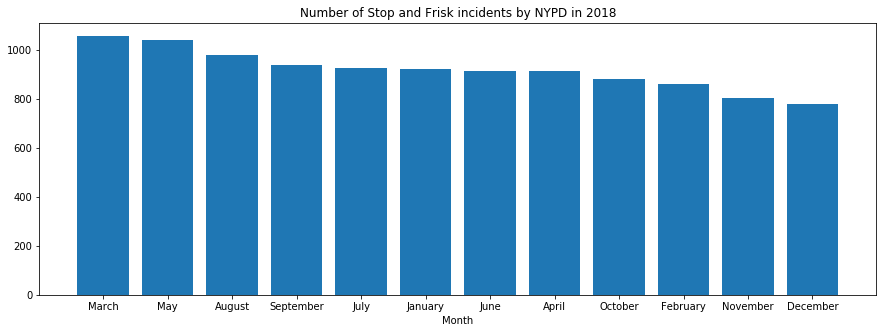

In [6]:
temp = sqf_df['MONTH2'].value_counts()
fig, ax = plt.subplots(1,1, figsize = (15, 5))
ax.bar(temp.index, temp.values)
ax.set_title("Number of Stop and Frisk incidents by NYPD in 2018")
ax.set_xlabel("Month");

### Visualizing Race

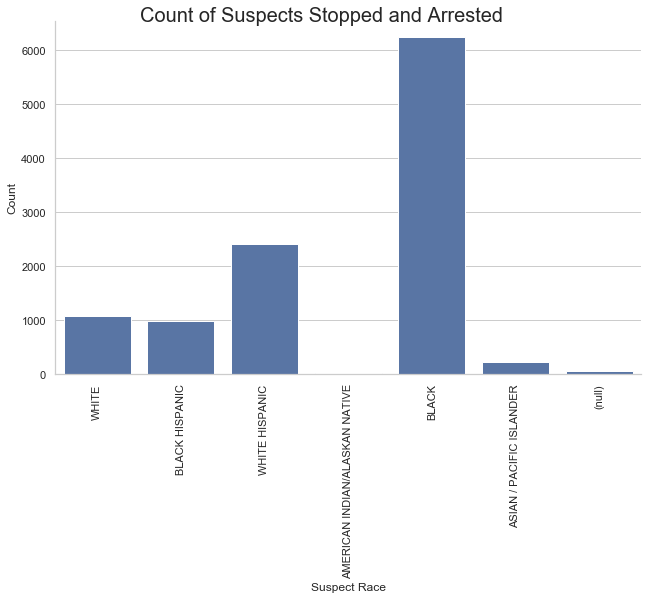

In [7]:
sqf_df['count'] = 1 # for color purpose later
sns.set(style="whitegrid")
# use hue='count' for one color
ax = sns.catplot(x="SUSPECT_RACE_DESCRIPTION", kind="count", data=sqf_df, hue="count", legend=False)
ax.fig.set_size_inches(10,6)
ax.set_axis_labels("Suspect Race", "Count")
ax.fig.suptitle("Count of Suspects Stopped and Arrested", fontsize = 20)
ax.set_xticklabels(rotation = 90);

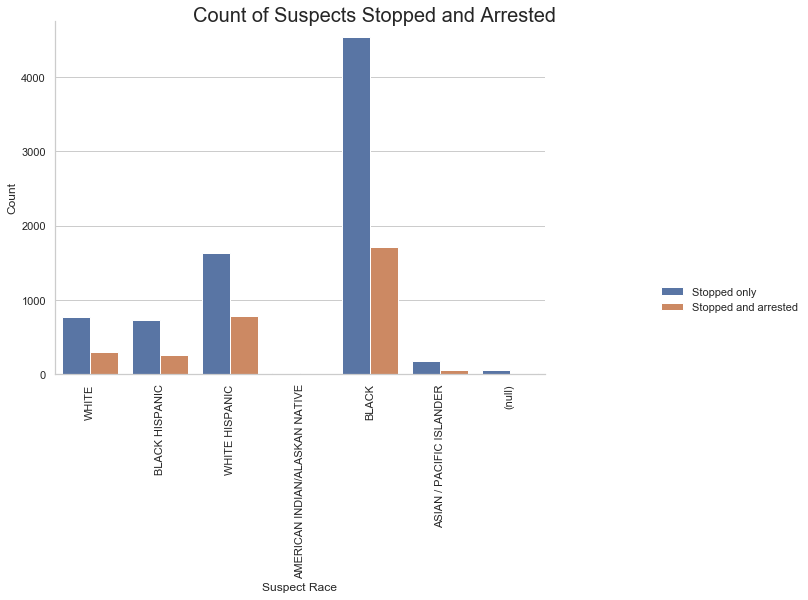

In [8]:
# temp = sqf_df['SUSPECT_RACE_DESCRIPTION'].value_counts()
sns.set(style="whitegrid")
ax = sns.catplot(x="SUSPECT_RACE_DESCRIPTION", hue="SUSPECT_ARRESTED_FLAG", kind="count", data=sqf_df)
ax.fig.set_size_inches(12,6)
ax.set_axis_labels("Suspect Race", "Count")
ax.fig.suptitle("Count of Suspects Stopped and Arrested", fontsize = 20)

# title
ax._legend.set_title("")

# legend
new_labels = ['Stopped only', 'Stopped and arrested']
for t, l in zip(ax._legend.texts, new_labels): 
    t.set_text(l)
ax.set_xticklabels(rotation = 90);

### Visualizing Gender

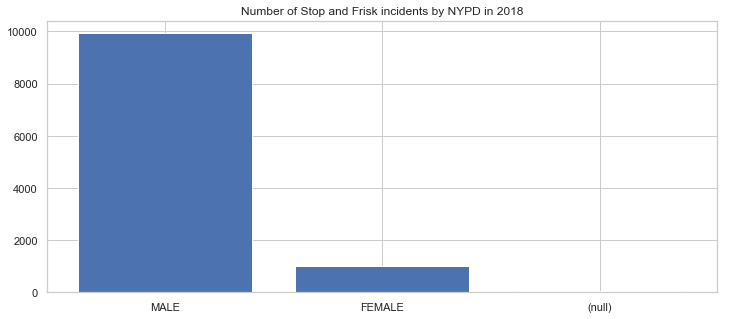

In [9]:
temp = sqf_df['SUSPECT_SEX'].value_counts()
fig, ax = plt.subplots(1,1, figsize = (12, 5))
ax.bar(temp.index, temp.values);
ax.set_title("Number of Stop and Frisk incidents by NYPD in 2018");

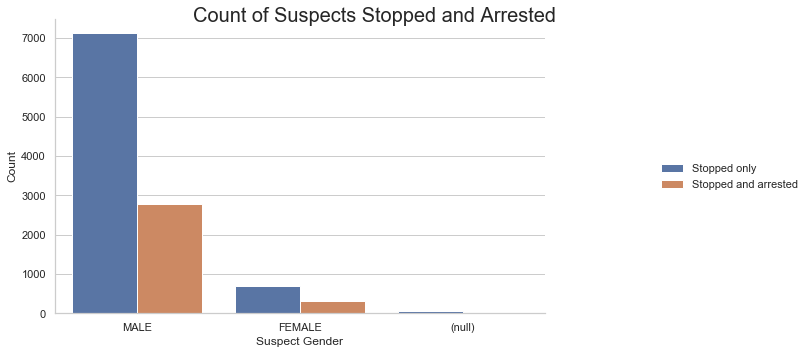

In [10]:
# temp = sqf_df['SUSPECT_RACE_DESCRIPTION'].value_counts()
sns.set(style="whitegrid")
ax = sns.catplot(x="SUSPECT_SEX", hue="SUSPECT_ARRESTED_FLAG", kind="count", data=sqf_df)
ax.fig.set_size_inches(12,5)
ax.set_axis_labels("Suspect Gender", "Count")
ax.fig.suptitle("Count of Suspects Stopped and Arrested", fontsize = 20)

# title
ax._legend.set_title("")

# legend
new_labels = ['Stopped only', 'Stopped and arrested']
for t, l in zip(ax._legend.texts, new_labels): 
    t.set_text(l);

### Visualizing Age

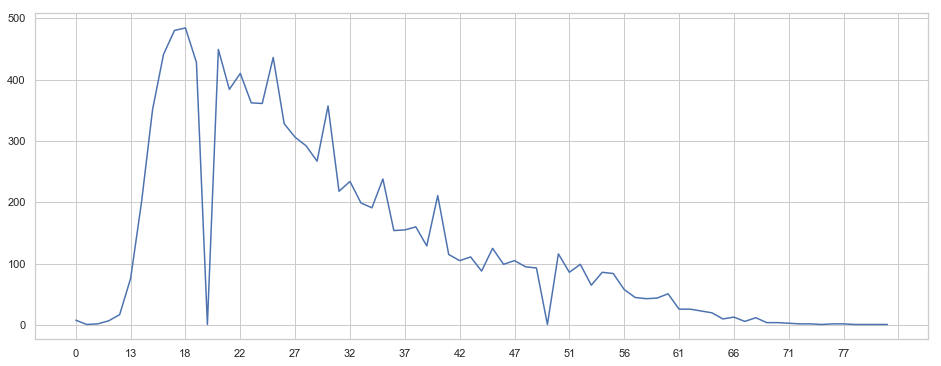

In [11]:
temp = dict(clean_sqf_df['SUSPECT_REPORTED_AGE'].value_counts())
keys = sorted(temp.keys())
values = [temp[k] for k in keys]

fig, ax = plt.subplots(1,1, figsize = (16, 6))
ax.set_xticks(range(0,100,5))
ax.plot(keys, values);

## Modeling

### Model 1: Random Forest Model Using Select Features

In [12]:
def top_k_features(features, feature_importances, k=10):
    indices = np.argsort(feature_importances)[-k:]
    return indices, features[indices], feature_importances[indices]

In [13]:
model_df = clean_sqf_df.select_dtypes(include=['int64', 'uint8', 'float64']).dropna(axis=0)
y = np.array(model_df['SUSPECT_ARRESTED_FLAG'])
X = model_df[model_df.columns.difference(['SUSPECT_ARRESTED_FLAG', 'SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model_1 = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
model_1 = model_1.fit(X_train, y_train)

print(model_1.score(X_train, y_train))
print(model_1.score(X_test, y_test))

0.7358439077636786
0.7409972299168975


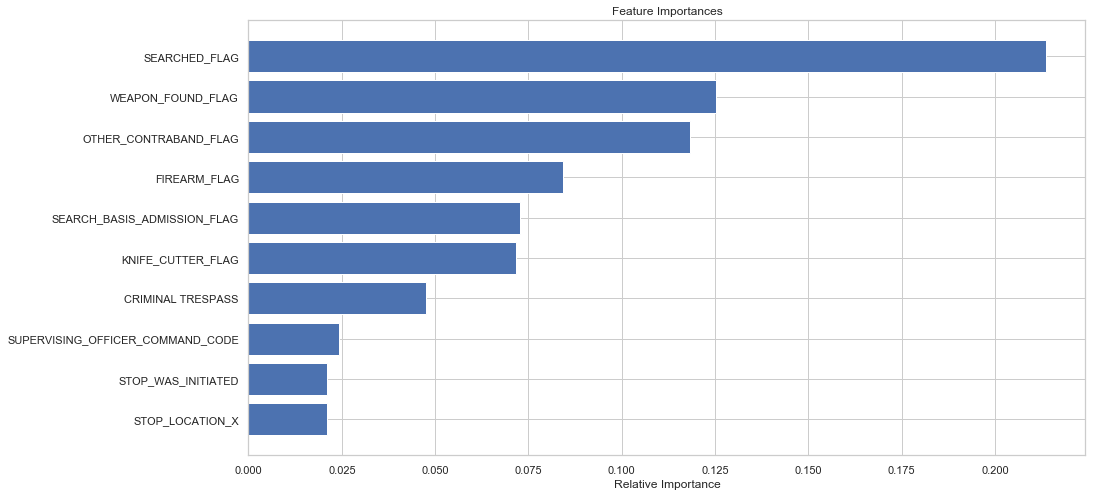

In [14]:
indices, features, importances = top_k_features(X_train.columns, model_1.feature_importances_, 10)

fig, ax = plt.subplots(figsize=(15,8))
ax.barh(range(len(indices)), importances, color='b', align='center')
ax.set_yticks(range(len(indices)))
ax.set_yticklabels(features)
ax.set_xlabel('Relative Importance')
ax.set_title('Feature Importances');

### Model 2: AdaBoost

In [15]:
base = DecisionTreeClassifier(max_depth=2)
model_2 = AdaBoostClassifier(n_estimators=10, base_estimator=base).fit(X_train, y_train)

print(model_2.score(X_train, y_train))
print(model_2.score(X_test, y_test))

0.8841588211215718
0.8947368421052632


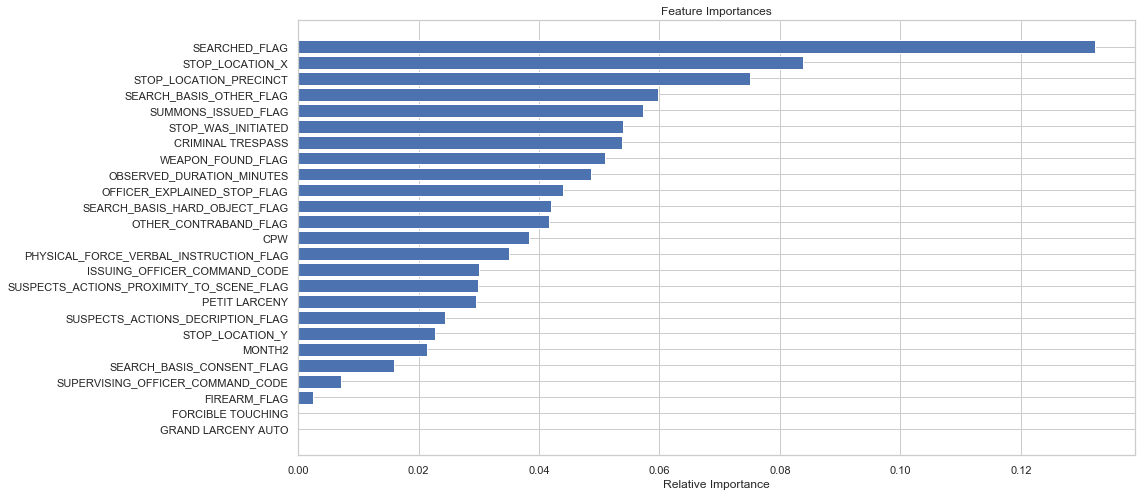

In [16]:
indices, features, importances = top_k_features(X_train.columns, model_2.feature_importances_, 25)

fig, ax = plt.subplots(figsize=(15,8))
ax.barh(range(len(indices)), importances, color='b', align='center')
ax.set_yticks(range(len(indices)))
ax.set_yticklabels(features)
ax.set_xlabel('Relative Importance')
ax.set_title('Feature Importances');

In [17]:
usable_cols = ['AUTO STRIPPIG',
               'BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG',
#                'BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG', 
               'BURGLARY', 
               'CPSP', 
#                'CPW', 
               'CRIMINAL MISCHIEF',
               'CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE',
               'CRIMINAL POSSESSION OF FORGED INSTRUMENT',
               'CRIMINAL POSSESSION OF MARIHUANA',
               'CRIMINAL SALE OF CONTROLLED SUBSTANCE', 
               'CRIMINAL SALE OF MARIHUANA',
               'CRIMINAL TRESPASS', 
               'FIREARM_FLAG', 
               'FORCIBLE TOUCHING',
#                'FRISKED_FLAG', 
               'GRAND LARCENY', 
               'GRAND LARCENY AUTO',
#                'ISSUING_OFFICER_COMMAND_CODE',
               'KNIFE_CUTTER_FLAG', 
               'MAKING GRAFFITI',  
#                'MENACING',
               'MURDER', 
#                'OBSERVED_DURATION_MINUTES',
               'OFFICER_EXPLAINED_STOP_FLAG', 
               'OFFICER_IN_UNIFORM_FLAG', 
               'OTHER',
               'OTHER_CONTRABAND_FLAG', 
               'OTHER_PERSON_STOPPED_FLAG',
               'OTHER_WEAPON_FLAG', 
               'PETIT LARCENY', 
               'PHYSICAL_FORCE_CEW_FLAG',
               'PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG',
               'PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG',
               'PHYSICAL_FORCE_OC_SPRAY_USED_FLAG', 
               'PHYSICAL_FORCE_OTHER_FLAG',
               'PHYSICAL_FORCE_RESTRAINT_USED_FLAG',
               'PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG',
               'PHYSICAL_FORCE_WEAPON_IMPACT_FLAG', 
               'PROSTITUTION', 
               'RAPE',
               'RECKLESS ENDANGERMENT', 
               'ROBBERY', 
               'SEARCH_BASIS_ADMISSION_FLAG', 
               'SEARCH_BASIS_CONSENT_FLAG',
               'SEARCH_BASIS_HARD_OBJECT_FLAG', 
#                'SEARCH_BASIS_OTHER_FLAG',
               'SEARCH_BASIS_OUTLINE_FLAG', 
#                'STOP_DURATION_MINUTES', 
               'STOP_WAS_INITIATED',
#                'SUMMONS_ISSUED_FLAG', 
#                'SUPERVISING_OFFICER_COMMAND_CODE',
               'SUSPECTS_ACTIONS_CASING_FLAG',
               'SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG',
               'SUSPECTS_ACTIONS_DECRIPTION_FLAG',
               'SUSPECTS_ACTIONS_DRUG_TRANSACTIONS_FLAG',
               'SUSPECTS_ACTIONS_IDENTIFY_CRIME_PATTERN_FLAG',
               'SUSPECTS_ACTIONS_LOOKOUT_FLAG', 
               'SUSPECTS_ACTIONS_OTHER_FLAG',
               'SUSPECTS_ACTIONS_PROXIMITY_TO_SCENE_FLAG',  
               'TERRORISM',
               'THEFT OF SERVICES', 
               'UNAUTHORIZED USE OF A VEHICLE',               
#                'SEARCHED_FLAG',
               'WEAPON_FOUND_FLAG'
              ]

unusable_cols = ['WHITE', 
                 'WHITE HISPANIC', 
                 'SUSPECT_SEX',
                 'STOP_LOCATION_X',
                 'STOP_LOCATION_Y',
                 'STOP_LOCATION_PRECINCT',
                 'STATEN ISLAND',
                 'QUEENS',
                 'MONTH2',
                 'MANHATTAN',
                 'DAY2',
                 'BLACK', 
                 'BLACK HISPANIC',
                 'BROOKLYN', 
                 'ASIAN / PACIFIC ISLANDER',
                 'ID_CARD_IDENTIFIES_OFFICER_FLAG', 
                 'SHIELD_IDENTIFIES_OFFICER_FLAG'
                 'VERBAL_IDENTIFIES_OFFICER_FLAG'
                ]

In [18]:
model_df = clean_sqf_df.select_dtypes(include=['int64', 'uint8', 'float64']).dropna(axis=0)
y = np.array(model_df['SUSPECT_ARRESTED_FLAG'])
X = model_df[model_df.columns.difference(['SUSPECT_ARRESTED_FLAG', 'SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG'])]
X = X[usable_cols].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape)

base = DecisionTreeClassifier(max_depth=2)
model_fair = AdaBoostClassifier(n_estimators=10, base_estimator=base).fit(X_train, y_train)

print(model_fair.score(X_train, y_train))
print(model_fair.score(X_test, y_test))

(7329, 54)
0.8025651521353527
0.7947368421052632


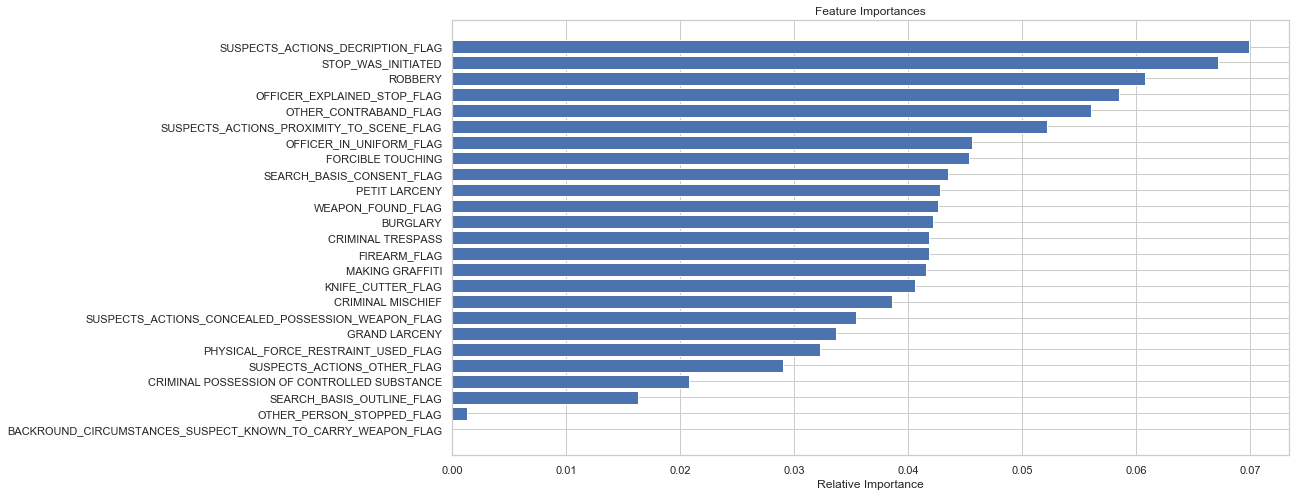

In [19]:
indices, features, importances = top_k_features(X_train.columns, model_fair.feature_importances_, 25)

fig, ax = plt.subplots(figsize=(15,8))
ax.barh(range(len(indices)), importances, color='b', align='center')
ax.set_yticks(range(len(indices)))
ax.set_yticklabels(features)
ax.set_xlabel('Relative Importance')
ax.set_title('Feature Importances');

### Exploring Location

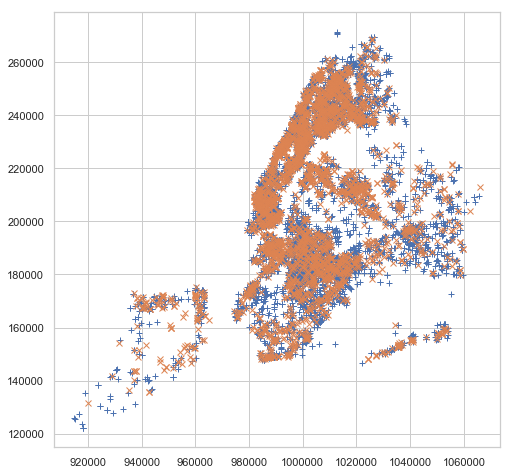

In [20]:
df_0 = model_df[model_df['SUSPECT_ARRESTED_FLAG'] == 0].copy()
df_1 = model_df[model_df['SUSPECT_ARRESTED_FLAG'] == 1].copy()
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(df_0['STOP_LOCATION_X'], df_0['STOP_LOCATION_Y'], '+', label='safe')
ax.plot(df_1['STOP_LOCATION_X'], df_1['STOP_LOCATION_Y'], 'x', label='arre')

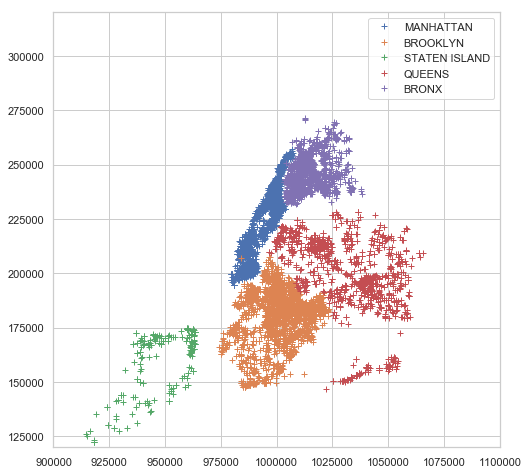

In [21]:
df = model_df[model_df['SUSPECT_ARRESTED_FLAG'] == 0].copy()
fig, ax = plt.subplots(figsize=(8,8))
boros = ['MANHATTAN', 'BRONX', 'BROOKLYN', 'STATEN ISLAND', 'QUEENS']

for boro in boros:
    if boro == 'BRONX':
        continue
    else:
        data = df[df[boro] == 1]
        ax.plot(data['STOP_LOCATION_X'], data['STOP_LOCATION_Y'], '+', label=boro)

# plotting Bronx
data = df[df['MANHATTAN'] + df['BROOKLYN'] + df['QUEENS'] + df['STATEN ISLAND'] == 0]
ax.plot(data['STOP_LOCATION_X'], data['STOP_LOCATION_Y'], '+', label='BRONX')

ax.legend()
ax.set_xlim(900000,1100000)
ax.set_ylim(120000, 320000);

In [22]:
df = sqf_df[sqf_df['SUSPECT_ARRESTED_FLAG'] == "Y"].copy()
boro_df = df.groupby(['STOP_LOCATION_BORO_NAME']).count()['STOP_FRISK_ID']

# population data = https://www.citypopulation.de/php/usa-newyorkcity.php
populations = {"BRONX": 1432132, "BROOKLYN": 2582830, "MANHATTAN": 1628701, "QUEENS": 2278906,
               "STATEN ISLAND": 476179}

norm_counts = {k:1000*v/populations[k] for k,v in zip(boro_df.index, boro_df)}
norm_counts

{'BRONX': 0.43711054567595725,
 'BROOKLYN': 0.35310105581861756,
 'MANHATTAN': 0.5532016005393255,
 'QUEENS': 0.24309910105989452,
 'STATEN ISLAND': 0.2562061745688071}

In [23]:
df = clean_sqf_df.copy()
precinct_df = df.groupby(['STOP_LOCATION_PRECINCT']).sum()['SUSPECT_ARRESTED_FLAG']
# precinct_df
df['STOP_LOCATION_X'].unique().shape

(6715,)

In [24]:
# clean_sqf_df[clean_sqf_df['FRISKED_FLAG'] + clean_sqf_df['SUSPECT_ARRESTED_FLAG'] == 2].shape
# clean_sqf_df[clean_sqf_df['SEARCHED_FLAG'] != clean_sqf_df['SUSPECT_ARRESTED_FLAG']].shape
clean_sqf_df[clean_sqf_df['SUSPECT_ARRESTED_FLAG'] == 1].shape
clean_sqf_df[clean_sqf_df['SEARCHED_FLAG'] + clean_sqf_df['SUSPECT_ARRESTED_FLAG'] == 2].shape

(2346, 111)

## Fairness Analysis

---